In [1]:
# LIST OF UPDATES
#
# Added bias (constant) to each linear layer
# Switched to using equivalent keras optimizer - SGD 
# Moved loss calculation to an independent function
# Switched to defining the network as Keras layers(!)
# Add tf.function to training loop - 10x speed increase(!)
# Switch to calculating gradients with keras 'trainable_weight' vs tf 'variables' 
# Tried using Keras Model.fit but order of magnitude slower than custom loop!
# Switch to train/val/test -> Showed that validation accuracy peaks at about 55% Training accuracy :(
# Switch to MeanSquaredError as loss function (But this is not a good error for classification)
# Add callback support to custom training loop
# Early completion based on validation changes
# Switch to correct method of regularisation with L2 Loss
# Addition of Dropout for regularisation
# Batch support (improves regularisation)
# Tried various train/test/val combinations - results are very sensitive to this.
# Tried various activation functions - "elu" seems best (not sure why yet)
# Switched to BinaryCrossEntropy loss function from keras
# Switched to Adam optimiser with scheduled learning
# Utilised log x-scale to compare model plot results
# Add Accuracy as a metric
# Add multiple plots to compare metrics
# TODO : Represent data using windowing method


In [2]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import numpy as np
import pandas as pd

import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils
from marketinsights.api.model import MarketInsightsModel
from marketinsights.remote.ml import MIAssembly

from tqdm import tqdm, trange
from functools import partialmethod

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt


tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

In [10]:
#DATASET_ID1 = "dbaab93d94795145539e595fab79f2d4"  # DOW
#DATASET_ID1 = "4234f0f1b6fcc17f6458696a6cdf5101"  # DOW
DATASET_ID1 = "09dcbc101dd03d999a479baa924901b3" # 2023 - Corrected 
NUM_FEATURES = (2 * 4) + 1

assembly = MIAssembly(secret="marketinsights-k8s-cred")

# Dataset
dataset, descriptor = assembly.get_dataset_by_id(DATASET_ID1, debug=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2013-01-02 15:00:00-05:00 to 2018-08-01 15:00:00-04:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1387 non-null   float64
 1   1       1387 non-null   float64
 2   2       1387 non-null   float64
 3   3       1387 non-null   float64
 4   4       1387 non-null   float64
 5   5       1387 non-null   float64
 6   6       1387 non-null   float64
 7   7       1387 non-null   float64
 8   8       1387 non-null   float64
 9   9       1387 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 119.2 KB


In [12]:
# Flip labels for Hinge loss function
labels = dataset[9]
labels[labels == 0] = -1
dataset[9] = labels
dataset

/tmp/ipykernel_18299/320720586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[labels == 0] = -1


,0,1,2,3,4,5,6,7,8,9
Date_Time,,,,,,,,,,
2013-01-02 15:00:00-05:00,0.390854,0.826284,0.199852,0.508756,0.504133,1.000000,0.000000,0.629408,0.051259,1
2013-01-03 15:00:00-05:00,0.766445,1.000000,0.586159,0.943148,0.943148,0.944016,0.000000,0.487062,0.108321,-1
2013-01-04 15:00:00-05:00,0.096991,1.000000,0.000000,0.631825,0.632902,0.905283,0.340489,0.847693,0.043706,1
2013-01-07 15:00:00-05:00,0.078908,0.468290,0.000000,0.337985,0.337655,1.000000,0.253843,0.984516,0.071635,1
2013-01-08 15:00:00-05:00,0.000000,0.748026,0.000000,0.685708,0.685012,1.000000,0.344723,0.518904,0.068146,1
...,...,...,...,...,...,...,...,...,...,...
2018-07-26 15:00:00-04:00,0.117785,0.779641,0.000000,0.500333,0.492980,1.000000,0.345889,0.654713,0.078719,-1
2018-07-27 15:00:00-04:00,0.378094,0.888481,0.000000,0.861922,0.845986,1.000000,0.287613,0.489824,0.109395,1
2018-07-30 15:00:00-04:00,0.307187,0.954621,0.000000,0.892212,0.903560,1.000000,0.369722,0.483388,0.102674,-1


In [13]:
dataset = tf.cast(dataset, tf.float32)

# Split into Train/Val/Test
n = len(dataset)
train_df = dataset[:1200]
val_df = dataset[1200:1300]
test_df = dataset[1300:]

# Split into features/labels
train_x, train_y = train_df[:, :NUM_FEATURES], train_df[:,NUM_FEATURES:]
val_x, val_y =  val_df[:, :NUM_FEATURES], val_df[:,NUM_FEATURES:]
test_x, test_y =  test_df[:, :NUM_FEATURES], test_df[:,NUM_FEATURES:]

In [247]:

def batches(x, y, batch_size):
    return [(batch, x[batch*batch_size:(batch+1)*batch_size], y[batch*batch_size:(batch+1)*batch_size]) for batch in range(int(len(x) / batch_size))]


def roundTan(x):
    x = tf.nn.tanh(mlmodel(x))
    x = tf.where(x < 0, -1., x)
    x = tf.where(x > 0, 1., x)
    return x

def train(mlmodel, epochs=100000, _callbacks=[]):
    
    callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=mlmodel)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=1000,
      decay_rate=1,
      staircase=False)

    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SquaredHinge()
    metric = tf.keras.losses.MeanSquaredError()
    accuracyMetric = tf.keras.metrics.Accuracy()
    val_accuracyMetric = tf.keras.metrics.Accuracy()
    
    @tf.function  # Make it fast.
    def train_on_batch(x, y):
        with tf.GradientTape() as tape:
                        
            loss = loss_fn(y_pred=tf.nn.tanh(mlmodel(x, training=True)), y_true=y) 
            regularization_loss=tf.add_n(mlmodel.losses)
            loss = loss# + regularization_loss
            
            #binary_cross_entropy = metric(y_pred=y_pred, y_true=y) 
            
            #val_binary_cross_entropy = metric(y_pred=val_y_pred, y_true=val_y)
            val_loss = loss_fn(y_pred=tf.nn.tanh(mlmodel(val_x)), y_true=val_y) 
            
            accuracy = accuracyMetric(y_pred=roundTan(x), y_true=y)
            val_accuracy = val_accuracyMetric(y_pred=roundTan(val_x), y_true=val_y)
            
            gradients = tape.gradient(loss, mlmodel.trainable_weights)
        optimizer.apply_gradients(zip(gradients, mlmodel.trainable_weights))
        return {
            "loss":loss, 
            "val_loss": val_loss, 
            #"metric":binary_cross_entropy, 
            #"val_metric":val_binary_cross_entropy, 
            "bob": accuracy,
            "val_bob": val_accuracy,
            "regularization_loss":regularization_loss}


    logs = {}
    mlmodel.stop_training = False

    
    callbacks.on_train_begin(logs=logs)

    # Format training loop
    for epoch in range(epochs):

        callbacks.on_epoch_begin(epoch, logs=logs)
        #mlmodel.reset_states() # Not needed?

        for batch, batch_x, batch_y in batches(train_x, train_y, 400):

            callbacks.on_batch_begin(batch, logs=logs)
            callbacks.on_train_batch_begin(batch, logs=logs)

            logs = train_on_batch(batch_x, batch_y)

            callbacks.on_train_batch_end(batch, logs=logs)
            callbacks.on_batch_end(batch, logs=logs)

        callbacks.on_epoch_end(epoch, logs=logs)

        if epoch % 100 == 0:
            accuracy = tf.keras.metrics.Accuracy()(roundTan(train_x), train_y)
            val_accuracy = tf.keras.metrics.Accuracy()(roundTan(val_x), val_y)
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}, Accuracy: {logs["bob"]}, Val Accuracy: {logs["val_bob"]}')

        if mlmodel.stop_training:
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}')
            break

    callbacks.on_train_end(logs=logs)

    # Fetch the history object we normally get from keras.fit
    history_object = None
    for cb in callbacks:
        if isinstance(cb, tf.keras.callbacks.History):
            history_object = cb
    assert history_object is not None
    
    return history_object

In [248]:
TOTAL_EPOCHS = 3000

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_bob', mode='max', verbose=1, start_from_epoch=500, patience=1000, restore_best_weights=True)
# Set up callbacks
callbacks = [earlyStopping]


In [249]:
histories = {}

In [250]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

histories["64x4"] = train(mlmodel, TOTAL_EPOCHS, callbacks)

Step 0 - Training Loss: 1.0642259120941162, Val Loss: 1.0191850662231445, Accuracy: 0.47833332419395447, Val Accuracy: 0.49666666984558105
Step 100 - Training Loss: 0.8504772782325745, Val Loss: 1.0394558906555176, Accuracy: 0.6100494861602783, Val Accuracy: 0.5086468458175659
Step 200 - Training Loss: 0.6841992735862732, Val Loss: 1.2160450220108032, Accuracy: 0.6712852120399475, Val Accuracy: 0.5017578601837158
Step 300 - Training Loss: 0.5805940628051758, Val Loss: 1.3182487487792969, Accuracy: 0.712992787361145, Val Accuracy: 0.4972757399082184
Step 400 - Training Loss: 0.4860297441482544, Val Loss: 1.357515573501587, Accuracy: 0.7452285885810852, Val Accuracy: 0.4944306015968323
Step 500 - Training Loss: 0.4120748043060303, Val Loss: 1.4150766134262085, Accuracy: 0.7712275385856628, Val Accuracy: 0.49567532539367676
Step 600 - Training Loss: 0.4084605276584625, Val Loss: 1.567192792892456, Accuracy: 0.7929866909980774, Val Accuracy: 0.4968996047973633
Step 700 - Training Loss: 0.3

In [ ]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

histories["64x4+DO"] = train(mlmodel, TOTAL_EPOCHS, callbacks)

Text(0.5, 0, 'Epochs')

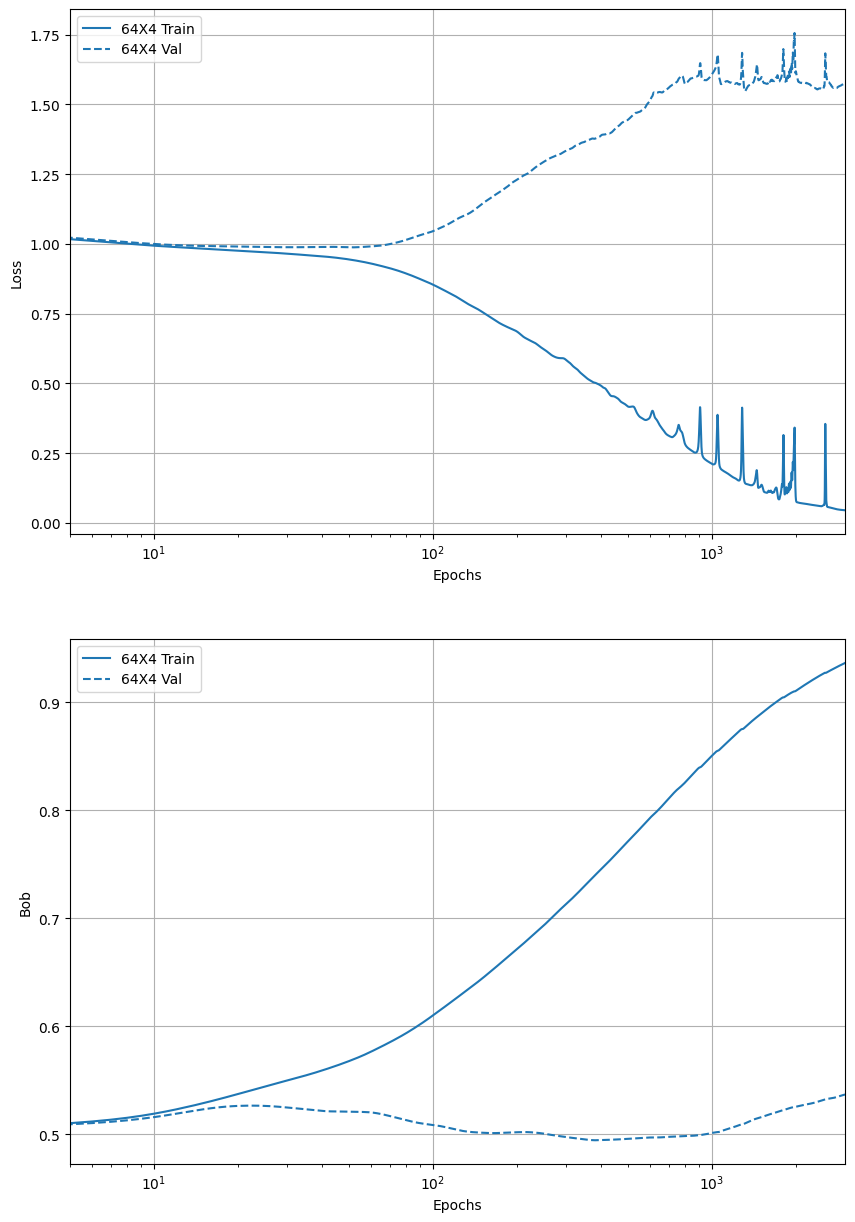

In [267]:
plt.rcParams['figure.figsize'] = [10, 15]

# PLOT histories
plt.subplot(211)
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10).plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.690, 0.705])
plt.xlabel("Epochs")

plt.subplot(212)
plotter = tfdocs.plots.HistoryPlotter(metric = 'bob', smoothing_std=10).plot(histories)
#plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.5, 0.55])
plt.xlabel("Epochs")





In [194]:
histories["64x4"].validation_data

In [257]:
tf.keras.metrics.Accuracy()(roundTan(val_x), val_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.57>

In [259]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(train_x))).numpy()), ppl.onehot(train_y.numpy()), threshold=0.5)

Won : 1189.0
Lost : 11.0
Total : 1200.0
Diff : 1178.0
Edge : 98.16666666666667%
Information Coefficient : 0.9816666841506958


0.99083334

In [260]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(val_x))).numpy()), ppl.onehot(val_y.numpy()), threshold=0.5)

Won : 57.0
Lost : 43.0
Total : 100.0
Diff : 14.0
Edge : 14.0%
Information Coefficient : 0.13999998569488525


0.57

In [266]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(test_x))).numpy()), ppl.onehot(test_y.numpy()), threshold=.50)

Won : 47.0
Lost : 40.0
Total : 87.0
Diff : 7.0
Edge : 8.045977011494253%
Information Coefficient : 0.08045971393585205


0.54022986

In [32]:
tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_pred=mlmodel(val_x), y_true=val_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.69821477>

In [258]:
def toSigmoid(x):
    return tf.where(x<0, 0., 1.)

In [263]:
mlmodel.save("great_model")

INFO:tensorflow:Assets written to: great_model/assets


In [264]:
mymodel = tf.keras.models.load_model('great_model')